# Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers import LeakyReLU
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.applications import ResNet50,MobileNetV2,EfficientNetB0,InceptionV3
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.metrics import accuracy_score

# Detecting TPU****

In [2]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


# Preparing Paths of Data

In [3]:
train_dir = '../input/plant-seedlings-classification/train'
test_dir = '../input/plant-seedlings-classification/test'

# Printing Number of images in each class

In [4]:
SPECIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
              'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse',
              'Small-flowered Cranesbill', 'Sugar beet']

for species in SPECIES:
    print('{} {} images'.format(species, len(os.listdir(os.path.join(train_dir, species)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


# Putting Paths in Train Data (to not consume memory)

In [5]:
train = []

for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        train.append(['../input/plant-seedlings-classification/train/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)
print(train)

Training Data:  (4750, 3)
                                                   file  species_num  \
0     ../input/plant-seedlings-classification/train/...            0   
1     ../input/plant-seedlings-classification/train/...            0   
2     ../input/plant-seedlings-classification/train/...            0   
3     ../input/plant-seedlings-classification/train/...            0   
4     ../input/plant-seedlings-classification/train/...            0   
...                                                 ...          ...   
4745  ../input/plant-seedlings-classification/train/...           11   
4746  ../input/plant-seedlings-classification/train/...           11   
4747  ../input/plant-seedlings-classification/train/...           11   
4748  ../input/plant-seedlings-classification/train/...           11   
4749  ../input/plant-seedlings-classification/train/...           11   

          species  
0     Black-grass  
1     Black-grass  
2     Black-grass  
3     Black-grass  
4     Bla

# Preprocessing Images

In [6]:
"""
The ranges that OpenCV manage for HSV format are the following:

For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].
"""
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # Hue Saturation Value, Hue is measured in degrees from 0 to 179

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50]) # represents H, S, V values
    upper_hsv = np.array([60 + sensitivity, 255, 255]) # # represents H, S, V values

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)) #(operation, size), creates a filter that has the shape of ellipse and size of 11x11
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel) # close holes
    
    return mask
"""
cv2.morphologyEx:
The closing operation is a combination of dilation followed by erosion.
It is typically used to close small holes or gaps in the foreground (white regions) and to smooth the boundaries of the objects.

cv2.getStructuringElement: to create a structuring element that will be used in morphological operations.
Morphological operations are commonly used in image processing for tasks like noise reduction, object extraction, and shape analysis.
"""

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask) #The result is an image where only the plant (detected based on the mask) is visible, and the rest is black.
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp
"""
Applies some noise
Applies Gaussian blur to the input image using cv2.GaussianBlur.
Creates a sharpened version of the image by combining the original image with the blurred image using cv2.addWeighted.
This step enhances the edges in the image.
"""

'\nApplies some noise\nApplies Gaussian blur to the input image using cv2.GaussianBlur.\nCreates a sharpened version of the image by combining the original image with the blurred image using cv2.addWeighted.\nThis step enhances the edges in the image.\n'

# Applying Preprocessing Techniques

In [7]:
x_train = []

for i in tqdm(range(len(train))):
    img = cv2.imread(train['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

100%|██████████| 4750/4750 [01:40<00:00, 47.30it/s]


# Plotting original image and preprocessed image

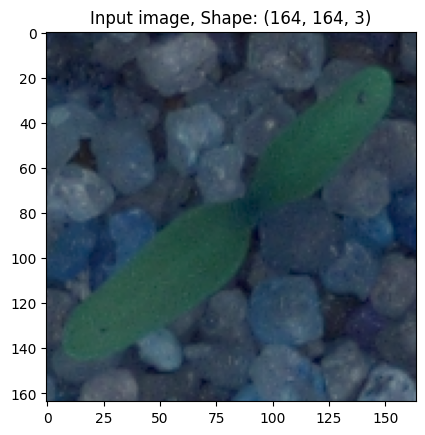

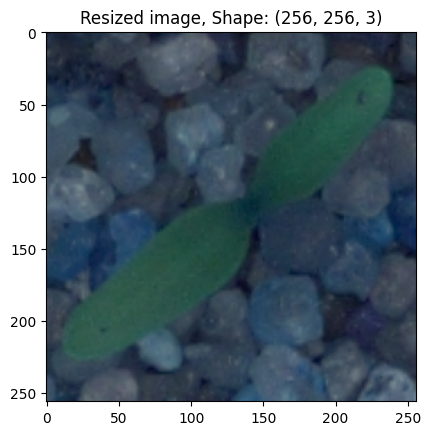

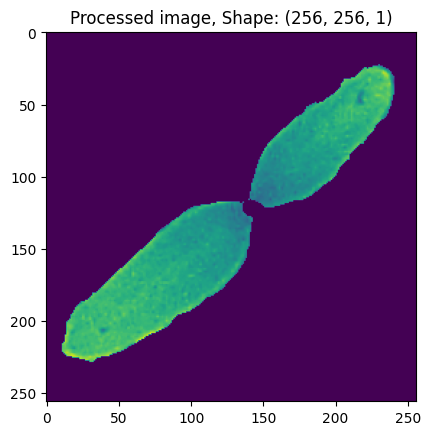

In [8]:
# Input image
Input_image = cv2.imread(train['file'][len(train)-1])

plt.imshow(Input_image)
plt.title('Input image, Shape: '+str(Input_image.shape))
plt.show()

# Resized image
plt.imshow(img)
plt.title('Resized image, Shape: '+str(img.shape))
plt.show()
        
# Processed image to Stack
plt.imshow(np.reshape(img_stack,(256,256)))
plt.title('Processed image, Shape: '+str(img_stack.shape))
plt.show()

In [9]:
labels = train['species_num']
labels = to_categorical(labels, num_classes = len(SPECIES))

# Splitting data to train and val

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.1, random_state=10)

In [11]:
print(x_train.shape)
print(x_val.shape)

(4275, 256, 256, 4)
(475, 256, 256, 4)


In [12]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)


Input Shape is : (256, 256, 4)


# Defining Learning Rate Schedule

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

# Applying Data Augmentation

In [14]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)

# Defining Training Parameters

In [15]:
batch_size = 64
epochs = 40
numClasses=len(SPECIES)

# Removing Forth channel (as there are models that only accept 3 channels)

In [16]:
preprocessed_xtrain=x_train[:, :, :, :3]
preprocessed_xval=x_val[:, :, :, :3]

inputShape=preprocessed_xtrain[1].shape

# don't uncomment this as it will take much time to train 
# history = model_new.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = epochs,
#                                   validation_data = (x_val,y_val), verbose = 1, 
#                                   steps_per_epoch=x_train.shape[0] // batch_size, 
#                                   callbacks=[learning_rate_reduction])

# Transfer Learning from ResNet 50

In [17]:
#Load Pretrained Resnet50
with strategy.scope():

    resNet_loader=ResNet50(weights='imagenet', include_top=False, input_shape=inputShape)
    # resNet_loader.summary()

    # Freeze the pre-trained layers
    for layer in resNet_loader.layers:
        layer.trainable = False

    # Adding a custom head for plant seedlings classification
    x = resNet_loader.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputLayer = Dense(numClasses, activation='softmax')(x)

    # Create the transfer learning model
    resNet_pretrained = Model(inputs=resNet_loader.input, outputs=outputLayer)
    resNet_pretrained.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# don't uncomment this as it will take much time to train 
# resNet_history = resNet_pretrained.fit_generator(datagen.flow(preprocessed_xtrain,y_train, batch_size=batch_size), epochs = epochs,
#                                   validation_data = (preprocessed_xval,y_val), verbose = 1, 
#                                   steps_per_epoch=x_train.shape[0] // batch_size, 
#                                   callbacks=[learning_rate_reduction])

94765736/94765736 [==============================] - 4s 0us/step


# Transfer Learning on Inception V3

In [18]:
#Load Pretrained Inception V3
with strategy.scope():

    inception_loader=InceptionV3(weights='imagenet', include_top=False, input_shape=inputShape)
    # resNet_loader.summary()

    # Freeze the pre-trained layers
    for layer in inception_loader.layers:
        layer.trainable = False

    # Adding a custom head for plant seedlings classification
    x = inception_loader.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputLayer = Dense(numClasses, activation='softmax')(x)

    # Create the transfer learning model
    inception_pretrained = Model(inputs=inception_loader.input, outputs=outputLayer)
    inception_pretrained.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# don't uncomment this as it will take much time to train 
# inception_history = inception_pretrained.fit_generator(datagen.flow(preprocessed_xtrain,y_train, batch_size=batch_size), epochs = epochs,
#                                   validation_data = (preprocessed_xval,y_val), verbose = 1, 
#                                   steps_per_epoch=x_train.shape[0] // batch_size, 
#                                   callbacks=[learning_rate_reduction])

87910968/87910968 [==============================] - 4s 0us/step


# Transfer Learning from MobileNet V2

In [19]:
#Load Pretrained MobileNetV2
with strategy.scope():
    
    #loaded v2 as it accepts(256,256) so I avoided resizing from (256,256) to (224,224) 
    mobileNet_loader=MobileNetV2(weights='imagenet', include_top=False)

    # Freeze the pre-trained layers
    for layer in mobileNet_loader.layers:
        layer.trainable = False

    # Adding a custom head for plant seedlings classification
    x = mobileNet_loader.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputLayer = Dense(numClasses, activation='softmax')(x)

    # Create the transfer learning model
    mobileNet_pretrained = Model(inputs=mobileNet_loader.input, outputs=outputLayer)
    mobileNet_pretrained.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# don't uncomment this as it will take much time to train 
# mobileNet_history = mobileNet_pretrained.fit_generator(datagen.flow(preprocessed_xtrain,y_train, batch_size=batch_size), epochs = epochs,
#                                   validation_data = (preprocessed_xval,y_val), verbose = 1, 
#                                   steps_per_epoch=x_train.shape[0] // batch_size, 
#                                   callbacks=[learning_rate_reduction])

9406464/9406464 [==============================] - 1s 0us/step


# Transfer Learning from EfficientNetB0

In [20]:
#Load Pretrained EfficientNetB0
with strategy.scope():

    efficientNet_loader=EfficientNetB0(weights='imagenet', include_top=False, input_shape=inputShape)
    # resNet_loader.summary()

    # Freeze the pre-trained layers
    for layer in resNet_loader.layers:
        layer.trainable = False

    # Adding a custom head for plant seedlings classification
    x = efficientNet_loader.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputLayer = Dense(numClasses, activation='softmax')(x)

    # Create the transfer learning model
    efficientNet_pretrained = Model(inputs=efficientNet_loader.input, outputs=outputLayer)
    efficientNet_pretrained.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# don't uncomment this as it will take much time to train 
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# efficientNet_history = efficientNet_pretrained.fit_generator(datagen.flow(preprocessed_xtrain,y_train, batch_size=batch_size), epochs = epochs,
#                                   validation_data = (preprocessed_xval,y_val), verbose = 1, 
#                                   steps_per_epoch=x_train.shape[0] // batch_size, 
#                                   callbacks=[learning_rate_reduction])

16705208/16705208 [==============================] - 1s 0us/step


# SqueezeNet Architecture

In [21]:
from IPython.display import Image, display

image_url = "https://i.ytimg.com/vi/W4UbinapGMY/maxresdefault.jpg"

# Displaying the image
display(Image(url=image_url, width=800, height=400))

In [22]:
"""
The key idea behind SqueezeNet is to strike a balance between model size and accuracy.
Traditional deep neural networks, while achieving high accuracy, often come with a large number of parameters, 
"""
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x

image_input=Input(shape=input_shape)

x = fire_incept((image_input), fire=16, intercept=16)

x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)

x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)

x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)

out = Dense(len(SPECIES), activation='softmax')(x)

model_new = Model(image_input, out)
model_new.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 4)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 126, 126, 16)         1616      ['input_5[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 16)         0         ['conv2d_94[0][0]']           
                                                                                                  
 conv2d_95 (Conv2D)          (None, 126, 126, 16)         2320      ['leaky_re_lu[0][0]']         
                                                                                            

# Compiling SqueezeNet Architecture

In [23]:
model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy'])

# Loading Models after Transfer Learning

In [24]:
SqueezeNet = tf.keras.models.load_model("/kaggle/input/trained-model/trained_model.h5")
ResNet50 = tf.keras.models.load_model("/kaggle/input/transferred-efficient-mobile-res-nets/ResNet50_transferred.h5")
MobileNetV2 = tf.keras.models.load_model("/kaggle/input/transferred-efficient-mobile-res-nets/MobileNetV2_transferred.h5")
EfficientNetB0 = tf.keras.models.load_model("/kaggle/input/transferred-efficient-mobile-res-nets/EfficientNetB0_transferred.h5")
InceptionV3 = tf.keras.models.load_model("/kaggle/input/transferred-efficient-mobile-res-nets/InceptionV3_transferred.h5")

# Preprocessing Test Data

In [25]:
test = []
for file in os.listdir(os.path.join(test_dir)):
    test.append(['../input/plant-seedlings-classification/test/{}'.format(file)])

test = pd.DataFrame(test, columns=['file'])
print(test.head(5))


x_test = []

for i in range(len(test)):
    img = cv2.imread(test['file'][i])
    img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_plant(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(256,256,1))
    x_test.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_test = np.array(x_test)

                                                file
0  ../input/plant-seedlings-classification/test/f...
1  ../input/plant-seedlings-classification/test/0...
2  ../input/plant-seedlings-classification/test/8...
3  ../input/plant-seedlings-classification/test/5...
4  ../input/plant-seedlings-classification/test/6...


In [26]:
preprocessed_xtest=x_test[:, :, :, :3]
print(preprocessed_xtest.shape)

(794, 256, 256, 3)


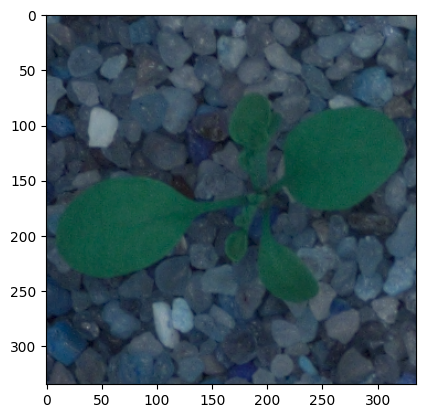

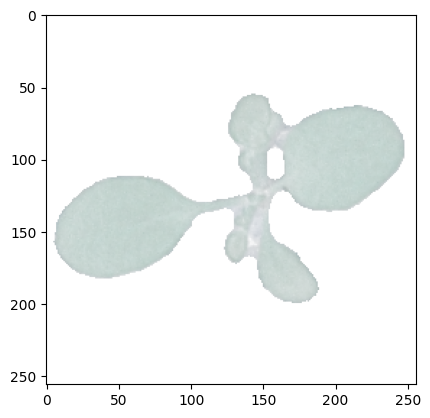

In [27]:
randm = np.random.randint(0,len(test))

img = cv2.imread(test['file'][randm])
plt.imshow(img)
plt.show()

img_processed = x_test[randm]
plt.imshow(img_processed)
plt.show()

# Measuring Scores of Models using Softmax layer

In [28]:
def measure_score(model, name, data, preprocessed_data, label, data_type):
    score = model.evaluate(data,label) if name == "SqueezeNet" else model.evaluate(preprocessed_data,label)
    print(f'Accuracy of {name} on {data_type} Set',score[1])

In [29]:
measure_score(SqueezeNet, "SqueezeNet", x_train, preprocessed_xtrain, y_train, "Train")
measure_score(ResNet50, "ResNet50", x_train, preprocessed_xtrain, y_train, "Train")
measure_score(MobileNetV2, "MobileNetV2", x_train, preprocessed_xtrain, y_train, "Train")
measure_score(EfficientNetB0, "EfficientNetB0", x_train, preprocessed_xtrain, y_train, "Train")
measure_score(InceptionV3, "InceptionV3", x_train, preprocessed_xtrain, y_train, "Train")
print("--------------------------------------------------------")
measure_score(SqueezeNet, "SqueezeNet", x_val, preprocessed_xval, y_val, "Validation")
measure_score(ResNet50, "ResNet50", x_val, preprocessed_xval, y_val, "Validation")
measure_score(MobileNetV2, "MobileNetV2", x_val, preprocessed_xval, y_val, "Validation")
measure_score(EfficientNetB0, "EfficientNetB0", x_val, preprocessed_xval, y_val, "Validation")
measure_score(InceptionV3, "InceptionV3", x_val, preprocessed_xval, y_val, "Validation")

134/134 [==============================] - 8s 20ms/step - loss: 0.2763 - accuracy: 0.8931
Accuracy of SqueezeNet on Train Set 0.8930994272232056
134/134 [==============================] - 11s 70ms/step - loss: 0.0975 - accuracy: 0.9649
Accuracy of ResNet50 on Train Set 0.9649122953414917
134/134 [==============================] - 6s 36ms/step - loss: 1.5495 - accuracy: 0.4814
Accuracy of MobileNetV2 on Train Set 0.48140349984169006
134/134 [==============================] - 9s 52ms/step - loss: 0.0275 - accuracy: 0.9995
Accuracy of EfficientNetB0 on Train Set 0.999532163143158
134/134 [==============================] - 10s 59ms/step - loss: 1.9800 - accuracy: 0.3345
Accuracy of InceptionV3 on Train Set 0.3345029354095459
--------------------------------------------------------
15/15 [==============================] - 1s 51ms/step - loss: 0.3740 - accuracy: 0.8758
Accuracy of SqueezeNet on Validation Set 0.87578946352005
15/15 [==============================] - 2s 109ms/step - loss: 0.2

# Getting Flattened Features from Models

In [30]:
def get_model_features(model, layer, name):
    model_feat = Model(inputs=model.input,outputs=model.get_layer(layer).output)

    feat_train = model_feat.predict(x_train) if name == "SqueezeNet" else model_feat.predict(preprocessed_xtrain)
    print(feat_train.shape)

    feat_val = model_feat.predict(x_val) if name == "SqueezeNet" else model_feat.predict(preprocessed_xval)
    print(feat_val.shape)
    
    return feat_train, feat_val

In [31]:
models_features = {}
models_features["SqueezeNet"] = get_model_features(SqueezeNet, "dense", "SqueezeNet")
models_features["ResNet50"] = get_model_features(ResNet50, "dense_2", "ResNet50")
models_features["MobileNetV2"] = get_model_features(MobileNetV2, "dense_16", "MobileNetV2")
models_features["EfficientNetB0"] = get_model_features(EfficientNetB0, "dense_8", "EfficientNetB0")
models_features["InceptionV3"] = get_model_features(InceptionV3, "dense_4", "InceptionV3")

134/134 [==============================] - 2s 12ms/step
(4275, 512)
15/15 [==============================] - 0s 12ms/step
(475, 512)
134/134 [==============================] - 9s 59ms/step
(4275, 512)
15/15 [==============================] - 1s 59ms/step
(475, 512)
134/134 [==============================] - 5s 27ms/step
(4275, 512)
15/15 [==============================] - 0s 27ms/step
(475, 512)
134/134 [==============================] - 7s 42ms/step
(4275, 512)
15/15 [==============================] - 1s 42ms/step
(475, 512)
134/134 [==============================] - 7s 44ms/step
(4275, 512)
15/15 [==============================] - 1s 44ms/step
(475, 512)


# Grey Wolf Optimization
refer to this paper: https://www.hindawi.com/journals/cmmm/2017/9512741/


In [32]:
def fitness(train_data, validation_data, mask, score):
    # Unpack the data tuples
    x_train, y_train = train_data
    x_val, y_val = validation_data

    # Apply the mask (on Train Data only)
    x_train = x_train * mask

    # Create and train the SVM model
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)

    # Make predictions on validation data
    y_pred = svm_model.predict(x_val)

    # Calculate the desired score
    if score == 'accuracy':
        result = accuracy_score(y_val, y_pred)
    elif score == 'F1':
        result = f1_score(y_val, y_pred, average='weighted')
    elif score == 'Precision':
        result = precision_score(y_val, y_pred, average='weighted')
    elif score == 'recall':
        result = recall_score(y_val, y_pred, average='weighted')
    else:
        raise ValueError("Invalid score. Please choose from 'accuracy', 'f1', 'precision', or 'recall'.")

    return result

In [33]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [34]:
def CalX(top_sample,curr_sample,a): #top sample represent alpha or beta or delta wolf
    # Define Parameter
    features_shape = curr_sample.shape
    A = 2*a*np.random.rand(*features_shape) - a
    C = 2*np.random.rand(*features_shape)
    D = abs(C*top_sample - curr_sample)

    # Calculating X_
    cstep = sigmoid(10*(A*D-0.5))
    bstep = np.where(cstep >= np.ones(features_shape),1,0)
    X = np.where(top_sample + bstep >= np.ones(features_shape),1,0)
    return X


def GWO_SVM(train_data,validation_data,score="accuracy",population_size=10,maxiter=5):
    # Initialize the population (wolfs), which actuallly represent masks
    population = np.random.randint(2,size = (population_size,*train_data[0].shape[1:])) # assuming it represent feature importance to add some diversity
    fitness_val = np.zeros(population_size)
    features_shape = train_data[0].shape[1:]

    # Calculating fitness value
    for sample in tqdm(range(population_size)):
        fitness_val[sample] = fitness(train_data,validation_data,population[sample],score)
        delta, beta, alpha = np.argsort(fitness_val)[-3:] # alpha in last so order is delta, beta, alpha


    for curr_iter in tqdm(range(maxiter)):
        # Initialize parameters;
        a = 2*(1 - curr_iter/maxiter) # linearly decreased from 2 to 0

        for idx in range(population_size):
            # Calculating for X1,X2 and X3
            X1 = CalX(alpha,population[idx],a)
            X2 = CalX(beta,population[idx],a)     
            X3 = CalX(delta,population[idx],a)

            # Greedy Selection
            new_point = sigmoid(np.mean((X1,X2,X3),axis=0)) #sigmoid function
            new_point = np.where(new_point>np.random.rand(*features_shape),1,0) #make it discrete
            new_fit = fitness(train_data,validation_data,new_point,score)

            # Update if Better
            if new_fit >= fitness_val[idx]:
                fitness_val[idx] = new_fit
                population[idx] = new_point


            # Recalculate new delta, beta, alpha
            delta, beta, alpha = np.argsort(fitness_val)[-3:]


    return population[alpha]

# Getting Masked Data from Gray Wolf Optimization after Optimizing

In [35]:
#note i use test data as validation data but MUST in report use validation set not test set
GWM_res = {}
GWM_res["SqueezeNet"] = GWO_SVM((models_features["SqueezeNet"][0], np.argmax(y_train,axis=1)), (models_features["SqueezeNet"][1], np.argmax(y_val,axis=1)),population_size=10,maxiter=5)
GWM_res["ResNet50"] = GWO_SVM((models_features["ResNet50"][0], np.argmax(y_train,axis=1)), (models_features["ResNet50"][1], np.argmax(y_val,axis=1)),population_size=10,maxiter=5)
GWM_res["MobileNetV2"] = GWO_SVM((models_features["MobileNetV2"][0], np.argmax(y_train,axis=1)), (models_features["MobileNetV2"][1], np.argmax(y_val,axis=1)),population_size=10,maxiter=5)
GWM_res["EfficientNetB0"] = GWO_SVM((models_features["EfficientNetB0"][0], np.argmax(y_train,axis=1)), (models_features["EfficientNetB0"][1], np.argmax(y_val,axis=1)),population_size=10,maxiter=5)
GWM_res["InceptionV3"] = GWO_SVM((models_features["InceptionV3"][0], np.argmax(y_train,axis=1)), (models_features["InceptionV3"][1], np.argmax(y_val,axis=1)),population_size=10,maxiter=5)

100%|██████████| 5/5 [04:52<00:00, 58.44s/it]


In [36]:
def applymask(train_data,mask):
    mask = np.where(mask > 0, True, False)
    #Apply Mask
    new_data = np.array(train_data[0][mask])
    for i in range(1,len(train_data)):
        new_data = np.vstack((new_data,train_data[i][mask]))

    return new_data

# Getting New Data after Extracting Important Features

In [37]:
new_data = {}
new_data["SqueezeNet"] = [applymask(models_features["SqueezeNet"][0],GWM_res["SqueezeNet"]), applymask(models_features["SqueezeNet"][1],GWM_res["SqueezeNet"])]
new_data["ResNet50"] = [applymask(models_features["ResNet50"][0],GWM_res["ResNet50"]), applymask(models_features["ResNet50"][1],GWM_res["ResNet50"])]
new_data["MobileNetV2"] = [applymask(models_features["MobileNetV2"][0],GWM_res["MobileNetV2"]), applymask(models_features["MobileNetV2"][1],GWM_res["MobileNetV2"])]
new_data["EfficientNetB0"] = [applymask(models_features["EfficientNetB0"][0],GWM_res["EfficientNetB0"]), applymask(models_features["EfficientNetB0"][1],GWM_res["EfficientNetB0"])]
new_data["InceptionV3"] = [applymask(models_features["InceptionV3"][0],GWM_res["InceptionV3"]), applymask(models_features["InceptionV3"][1],GWM_res["InceptionV3"])]
print(new_data["EfficientNetB0"][1].shape)

(475, 364)


# Apply SVM on all Models's Extracted Features

In [38]:
# Create and train the SVM model
svm_model = svm.SVC()

for i in new_data.keys():
    svm_model.fit(new_data[i][0], np.argmax(y_train,axis=1))

    # Make predictions on the train data
    y_pred_train = svm_model.predict(new_data[i][0])

    # Make predictions on the val data
    y_pred_val = svm_model.predict(new_data[i][1])

    # Calculate accuracy
    accuracy_train = accuracy_score(np.argmax(y_train,axis=1), y_pred_train)
    accuracy_val = accuracy_score(np.argmax(y_val,axis=1), y_pred_val)
    
    print(f"\nTrain accuracy: {accuracy_train}, Val accuracy: {accuracy_val} of {i} no.features reduced from {models_features[i][0].shape[1]} to {new_data[i][0].shape[1]}")
    print(f"\nPrecision: {precision_score(np.argmax(y_val,axis=1), y_pred_val, average='weighted')}, of {i}")
    print(f"\nRecall: {recall_score(np.argmax(y_val,axis=1), y_pred_val, average='weighted')}, of {i}")
    print(f"\nF1 Score: {f1_score(np.argmax(y_val,axis=1), y_pred_val, average='weighted')}, of {i}")
    print("----------------------------------------------------------------------------------")


Train accuracy: 0.9284210526315789, Val accuracy: 0.9031578947368422 of SqueezeNet no.features reduced from 512 to 375

Precision: 0.9209656092315788, of SqueezeNet

Recall: 0.9031578947368422, of SqueezeNet

F1 Score: 0.8871579175493358, of SqueezeNet
----------------------------------------------------------------------------------

Train accuracy: 0.9681871345029239, Val accuracy: 0.9284210526315789 of ResNet50 no.features reduced from 512 to 387

Precision: 0.9306024263340915, of ResNet50

Recall: 0.9284210526315789, of ResNet50

F1 Score: 0.923750968290883, of ResNet50
----------------------------------------------------------------------------------

Train accuracy: 0.6049122807017544, Val accuracy: 0.5515789473684211 of MobileNetV2 no.features reduced from 512 to 378

Precision: 0.5356044194973523, of MobileNetV2

Recall: 0.5515789473684211, of MobileNetV2

F1 Score: 0.5280127285092716, of MobileNetV2
-----------------------------------------------------------------------------

# Submitting to Competition

## Fitting SVM on EfficientNetB0 Features

In [39]:
model_feat = Model(inputs=EfficientNetB0.input,outputs=EfficientNetB0.get_layer("dense_8").output)
featueres_XTrain=model_feat.predict(preprocessed_xtrain)
features_xTest=model_feat.predict(preprocessed_xtest)

SVM_testmodel = svm.SVC()
SVM_testmodel.fit(featueres_XTrain, np.argmax(y_train,axis=1))

25/25 [==============================] - 2s 63ms/step


SVC()

## Predicting Using SVM

In [40]:
Predicted_labels=SVM_testmodel.predict(features_xTest)

## Mapping Predicted Labels to Classes Strings

In [41]:
categoricalSpecies={}

for species in range(len(SPECIES)):
    categoricalSpecies[species]=SPECIES[species]

In [42]:
stored_categorical_predicted=[]

for i in Predicted_labels:
    stored_categorical_predicted.append(categoricalSpecies[i])

# Creating Submission File

In [43]:
submission = pd.DataFrame({'file': os.listdir(test_dir), 'species':stored_categorical_predicted })

submission.to_csv('submission.csv', index=False)